# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [19]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [20]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [21]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [22]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    
    train_images = datasets.ImageFolder(data_dir, transform)
    
    dataloader = torch.utils.data.DataLoader(dataset=train_images, batch_size=batch_size, shuffle=True)
    return dataloader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [23]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

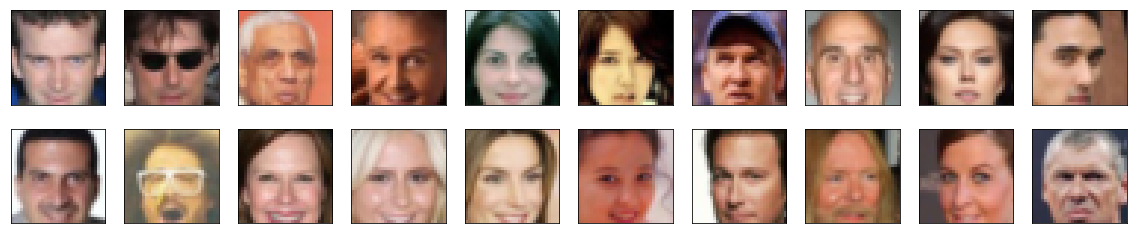

In [24]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [25]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min, max = feature_range
    x = x * (max-min) + min
    
    return x


In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9529)
Max:  tensor(0.8745)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [27]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
     
    return nn.Sequential(*layers)

In [28]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        self.dropout = nn.Dropout(0.2)
        
        self.conv_dim = conv_dim
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        
        # define feedforward behavior for D
        # conv layers
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.dropout(x)
        
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.dropout(x)
        
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.dropout(x)
        
        # flatten the image
        x = x.view(-1, self.conv_dim*4*4*4)
        # final (fully connected) layer
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [29]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                       kernel_size, stride, padding, bias=False)
    
    layers.append(deconv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [30]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        
        self.conv_dim = conv_dim

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior for G
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.tanh(self.deconv3(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [31]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__

    # TODO: Apply initial weights to convolutional and linear layers

    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(mean=0.0, std=0.02)
        if not classname.find('Linear') == -1:
            m.bias.data.fill_(0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [32]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

#### Exercise: Define model hyperparameters

In [33]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.2)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [35]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    lbl = torch.ones(batch_size)
    if train_on_gpu:
        lbl = lbl.cuda()

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), lbl)
    return loss
#     return torch.mean((D_out-1)**2)

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    lbl = torch.zeros(batch_size)
    
    if train_on_gpu:
        lbl = lbl.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), lbl)
    
    return loss
#     return torch.mean(D_out**2)

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [36]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.3
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [37]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            
            # ===============================================
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            # move data to GPU
            if train_on_gpu:
                real_images = real_images.cuda()
                
            # calculate loss on real images
            d_out_real = D(real_images)
            d_loss_real = real_loss(d_out_real)
            
            # generate fakes
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # calculate loss on fakes
            d_out_fake = D(fake_images)
            d_loss_fake = fake_loss(d_out_fake)
            
            # accumelate losses
            d_loss = d_loss_real+d_loss_fake
            
            # backprop step
            d_loss.backward()
            d_optimizer.step()
            
            
            # ===============================================
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()

            # generate fakes
            # what if I used the same fake images?
            j = np.random.uniform(-1, 1, size=(batch_size, z_size))
            j = torch.from_numpy(j).float()
            if train_on_gpu:
                j = j.cuda()
            
            fake_images = G(j)
            
            # calculate discriminator fake loss
            d_out_fake = D(fake_images)
            g_loss = real_loss(d_out_fake)
            
            # back prop and optim step
            g_loss.backward()
            g_optimizer.step()
            
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [43]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.3553 | g_loss: 1.0731
Epoch [    1/   50] | d_loss: 1.1312 | g_loss: 1.2262
Epoch [    1/   50] | d_loss: 1.1919 | g_loss: 1.1413
Epoch [    1/   50] | d_loss: 1.1272 | g_loss: 1.2538
Epoch [    1/   50] | d_loss: 1.2704 | g_loss: 1.0393
Epoch [    1/   50] | d_loss: 1.7776 | g_loss: 0.9159
Epoch [    1/   50] | d_loss: 0.9577 | g_loss: 0.9985
Epoch [    1/   50] | d_loss: 1.0259 | g_loss: 0.9399
Epoch [    1/   50] | d_loss: 1.3300 | g_loss: 1.1225
Epoch [    1/   50] | d_loss: 1.2168 | g_loss: 0.9594
Epoch [    1/   50] | d_loss: 1.5776 | g_loss: 0.9786
Epoch [    1/   50] | d_loss: 0.6768 | g_loss: 1.1981
Epoch [    1/   50] | d_loss: 1.2499 | g_loss: 0.7548
Epoch [    1/   50] | d_loss: 0.9557 | g_loss: 0.7517
Epoch [    1/   50] | d_loss: 1.4015 | g_loss: 0.8984
Epoch [    1/   50] | d_loss: 1.2626 | g_loss: 0.6582
Epoch [    1/   50] | d_loss: 1.2332 | g_loss: 0.6629
Epoch [    1/   50] | d_loss: 1.1141 | g_loss: 0.8352
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 1.2512 | g_loss: 0.8005
Epoch [    3/   50] | d_loss: 0.8669 | g_loss: 1.1426
Epoch [    3/   50] | d_loss: 1.1973 | g_loss: 0.8790
Epoch [    3/   50] | d_loss: 0.9316 | g_loss: 1.3971
Epoch [    4/   50] | d_loss: 1.3709 | g_loss: 0.9847
Epoch [    4/   50] | d_loss: 0.8256 | g_loss: 1.4380
Epoch [    4/   50] | d_loss: 1.2454 | g_loss: 0.9174
Epoch [    4/   50] | d_loss: 1.2091 | g_loss: 1.0284
Epoch [    4/   50] | d_loss: 1.5799 | g_loss: 1.1087
Epoch [    4/   50] | d_loss: 1.1912 | g_loss: 0.9485
Epoch [    4/   50] | d_loss: 1.4141 | g_loss: 1.1776
Epoch [    4/   50] | d_loss: 1.1111 | g_loss: 1.0553
Epoch [    4/   50] | d_loss: 1.3672 | g_loss: 0.9661
Epoch [    4/   50] | d_loss: 1.4128 | g_loss: 1.0820
Epoch [    4/   50] | d_loss: 1.3228 | g_loss: 0.9771
Epoch [    4/   50] | d_loss: 0.8589 | g_loss: 1.5368
Epoch [    4/   50] | d_loss: 0.9892 | g_loss: 0.9382
Epoch [    4/   50] | d_loss: 1.7711 | g_loss: 1.3246
Epoch [    4/   50] | d_loss

Epoch [    6/   50] | d_loss: 1.1395 | g_loss: 1.1516
Epoch [    6/   50] | d_loss: 1.4417 | g_loss: 1.0063
Epoch [    6/   50] | d_loss: 1.1566 | g_loss: 1.4245
Epoch [    6/   50] | d_loss: 0.7748 | g_loss: 0.9697
Epoch [    6/   50] | d_loss: 1.1072 | g_loss: 1.3141
Epoch [    6/   50] | d_loss: 1.1959 | g_loss: 0.9109
Epoch [    6/   50] | d_loss: 1.1609 | g_loss: 1.2350
Epoch [    6/   50] | d_loss: 1.1878 | g_loss: 0.9988
Epoch [    7/   50] | d_loss: 0.8838 | g_loss: 1.1181
Epoch [    7/   50] | d_loss: 0.8379 | g_loss: 1.5438
Epoch [    7/   50] | d_loss: 0.9263 | g_loss: 1.0446
Epoch [    7/   50] | d_loss: 1.2374 | g_loss: 0.9776
Epoch [    7/   50] | d_loss: 0.9040 | g_loss: 1.1442
Epoch [    7/   50] | d_loss: 0.9922 | g_loss: 1.1680
Epoch [    7/   50] | d_loss: 1.4916 | g_loss: 0.9594
Epoch [    7/   50] | d_loss: 1.0979 | g_loss: 1.0348
Epoch [    7/   50] | d_loss: 1.1820 | g_loss: 1.2171
Epoch [    7/   50] | d_loss: 1.2361 | g_loss: 1.3291
Epoch [    7/   50] | d_loss

Epoch [    9/   50] | d_loss: 1.1062 | g_loss: 0.9122
Epoch [    9/   50] | d_loss: 1.3664 | g_loss: 1.2010
Epoch [    9/   50] | d_loss: 0.7516 | g_loss: 1.1863
Epoch [    9/   50] | d_loss: 1.2569 | g_loss: 0.6302
Epoch [    9/   50] | d_loss: 0.9439 | g_loss: 1.3746
Epoch [    9/   50] | d_loss: 0.9331 | g_loss: 1.2904
Epoch [    9/   50] | d_loss: 0.8382 | g_loss: 1.5524
Epoch [    9/   50] | d_loss: 0.9891 | g_loss: 1.1582
Epoch [    9/   50] | d_loss: 1.0993 | g_loss: 1.2496
Epoch [    9/   50] | d_loss: 1.3144 | g_loss: 1.1521
Epoch [    9/   50] | d_loss: 1.0751 | g_loss: 1.2256
Epoch [    9/   50] | d_loss: 1.0698 | g_loss: 1.5412
Epoch [   10/   50] | d_loss: 1.2713 | g_loss: 0.8007
Epoch [   10/   50] | d_loss: 0.7193 | g_loss: 1.3952
Epoch [   10/   50] | d_loss: 1.1987 | g_loss: 1.2551
Epoch [   10/   50] | d_loss: 1.1512 | g_loss: 1.4338
Epoch [   10/   50] | d_loss: 1.1956 | g_loss: 0.6252
Epoch [   10/   50] | d_loss: 1.3411 | g_loss: 1.0336
Epoch [   10/   50] | d_loss

Epoch [   12/   50] | d_loss: 1.1847 | g_loss: 1.1464
Epoch [   12/   50] | d_loss: 1.3015 | g_loss: 1.1147
Epoch [   12/   50] | d_loss: 1.1987 | g_loss: 0.9864
Epoch [   12/   50] | d_loss: 0.8185 | g_loss: 1.7078
Epoch [   12/   50] | d_loss: 1.2556 | g_loss: 1.1707
Epoch [   12/   50] | d_loss: 1.3639 | g_loss: 1.7338
Epoch [   12/   50] | d_loss: 0.9976 | g_loss: 1.3824
Epoch [   12/   50] | d_loss: 0.4621 | g_loss: 1.2975
Epoch [   12/   50] | d_loss: 1.1644 | g_loss: 1.1449
Epoch [   12/   50] | d_loss: 0.7288 | g_loss: 1.4363
Epoch [   12/   50] | d_loss: 1.0134 | g_loss: 1.2531
Epoch [   12/   50] | d_loss: 1.1963 | g_loss: 0.8776
Epoch [   12/   50] | d_loss: 1.3124 | g_loss: 1.7637
Epoch [   12/   50] | d_loss: 0.5386 | g_loss: 1.8148
Epoch [   12/   50] | d_loss: 0.8892 | g_loss: 1.3777
Epoch [   12/   50] | d_loss: 0.9935 | g_loss: 0.9821
Epoch [   13/   50] | d_loss: 1.2915 | g_loss: 1.2269
Epoch [   13/   50] | d_loss: 1.3079 | g_loss: 1.3480
Epoch [   13/   50] | d_loss

Epoch [   15/   50] | d_loss: 1.2305 | g_loss: 1.6311
Epoch [   15/   50] | d_loss: 0.8960 | g_loss: 1.4859
Epoch [   15/   50] | d_loss: 1.2617 | g_loss: 1.4314
Epoch [   15/   50] | d_loss: 1.0617 | g_loss: 0.9468
Epoch [   15/   50] | d_loss: 0.8824 | g_loss: 1.6042
Epoch [   15/   50] | d_loss: 0.6735 | g_loss: 1.1645
Epoch [   15/   50] | d_loss: 0.9801 | g_loss: 1.9992
Epoch [   15/   50] | d_loss: 0.8554 | g_loss: 0.9893
Epoch [   15/   50] | d_loss: 0.9661 | g_loss: 0.9507
Epoch [   15/   50] | d_loss: 0.8588 | g_loss: 2.2285
Epoch [   15/   50] | d_loss: 0.8187 | g_loss: 1.5069
Epoch [   15/   50] | d_loss: 0.8835 | g_loss: 1.6733
Epoch [   15/   50] | d_loss: 0.7158 | g_loss: 1.8047
Epoch [   15/   50] | d_loss: 1.4821 | g_loss: 0.7071
Epoch [   15/   50] | d_loss: 1.3840 | g_loss: 1.5244
Epoch [   15/   50] | d_loss: 0.8593 | g_loss: 1.2406
Epoch [   15/   50] | d_loss: 0.9560 | g_loss: 1.0836
Epoch [   15/   50] | d_loss: 0.8082 | g_loss: 1.2105
Epoch [   15/   50] | d_loss

Epoch [   18/   50] | d_loss: 1.3698 | g_loss: 1.4728
Epoch [   18/   50] | d_loss: 1.3910 | g_loss: 1.3006
Epoch [   18/   50] | d_loss: 0.9236 | g_loss: 1.6555
Epoch [   18/   50] | d_loss: 1.0515 | g_loss: 1.3918
Epoch [   18/   50] | d_loss: 1.5992 | g_loss: 1.2887
Epoch [   18/   50] | d_loss: 0.7157 | g_loss: 1.0761
Epoch [   18/   50] | d_loss: 0.6556 | g_loss: 1.3683
Epoch [   18/   50] | d_loss: 0.9202 | g_loss: 1.2981
Epoch [   18/   50] | d_loss: 1.2940 | g_loss: 1.5659
Epoch [   18/   50] | d_loss: 1.3514 | g_loss: 2.4626
Epoch [   18/   50] | d_loss: 0.4732 | g_loss: 1.6031
Epoch [   18/   50] | d_loss: 0.5818 | g_loss: 1.2771
Epoch [   18/   50] | d_loss: 1.2198 | g_loss: 1.3051
Epoch [   18/   50] | d_loss: 0.8346 | g_loss: 1.4606
Epoch [   18/   50] | d_loss: 0.5831 | g_loss: 0.8404
Epoch [   18/   50] | d_loss: 1.2292 | g_loss: 1.5509
Epoch [   18/   50] | d_loss: 0.7537 | g_loss: 1.0631
Epoch [   18/   50] | d_loss: 0.8911 | g_loss: 0.7072
Epoch [   18/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.5085 | g_loss: 2.6250
Epoch [   21/   50] | d_loss: 0.8157 | g_loss: 1.5995
Epoch [   21/   50] | d_loss: 0.6336 | g_loss: 1.7798
Epoch [   21/   50] | d_loss: 1.0550 | g_loss: 1.8779
Epoch [   21/   50] | d_loss: 0.5087 | g_loss: 1.0605
Epoch [   21/   50] | d_loss: 0.7985 | g_loss: 1.1876
Epoch [   21/   50] | d_loss: 1.2940 | g_loss: 1.0267
Epoch [   21/   50] | d_loss: 0.7803 | g_loss: 1.2135
Epoch [   21/   50] | d_loss: 1.5256 | g_loss: 1.3448
Epoch [   21/   50] | d_loss: 0.6444 | g_loss: 2.3307
Epoch [   21/   50] | d_loss: 1.0983 | g_loss: 2.0292
Epoch [   21/   50] | d_loss: 1.2494 | g_loss: 1.7073
Epoch [   21/   50] | d_loss: 0.5154 | g_loss: 1.3421
Epoch [   21/   50] | d_loss: 0.9145 | g_loss: 1.7563
Epoch [   21/   50] | d_loss: 1.1431 | g_loss: 1.2384
Epoch [   21/   50] | d_loss: 0.8944 | g_loss: 0.9085
Epoch [   21/   50] | d_loss: 1.5039 | g_loss: 0.7385
Epoch [   21/   50] | d_loss: 1.3272 | g_loss: 1.5007
Epoch [   21/   50] | d_loss

Epoch [   24/   50] | d_loss: 1.1183 | g_loss: 2.4053
Epoch [   24/   50] | d_loss: 1.3648 | g_loss: 0.7116
Epoch [   24/   50] | d_loss: 1.5973 | g_loss: 1.5134
Epoch [   24/   50] | d_loss: 0.8447 | g_loss: 0.2065
Epoch [   24/   50] | d_loss: 0.9684 | g_loss: 1.6163
Epoch [   24/   50] | d_loss: 1.2302 | g_loss: 1.9051
Epoch [   24/   50] | d_loss: 0.7880 | g_loss: 1.9392
Epoch [   24/   50] | d_loss: 0.9099 | g_loss: 2.0710
Epoch [   24/   50] | d_loss: 0.6105 | g_loss: 1.2068
Epoch [   24/   50] | d_loss: 1.2336 | g_loss: 1.1557
Epoch [   24/   50] | d_loss: 0.6915 | g_loss: 2.0326
Epoch [   24/   50] | d_loss: 1.4358 | g_loss: 0.9904
Epoch [   24/   50] | d_loss: 0.9741 | g_loss: 1.4771
Epoch [   24/   50] | d_loss: 1.4750 | g_loss: 1.1958
Epoch [   24/   50] | d_loss: 1.0619 | g_loss: 1.8055
Epoch [   24/   50] | d_loss: 1.0978 | g_loss: 1.9832
Epoch [   24/   50] | d_loss: 0.7674 | g_loss: 1.5970
Epoch [   24/   50] | d_loss: 0.7731 | g_loss: 1.5070
Epoch [   24/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.7321 | g_loss: 2.0085
Epoch [   27/   50] | d_loss: 0.7052 | g_loss: 1.0740
Epoch [   27/   50] | d_loss: 0.9962 | g_loss: 1.5622
Epoch [   27/   50] | d_loss: 0.8417 | g_loss: 1.5796
Epoch [   27/   50] | d_loss: 1.0195 | g_loss: 1.0468
Epoch [   27/   50] | d_loss: 1.2501 | g_loss: 1.0843
Epoch [   27/   50] | d_loss: 1.3425 | g_loss: 1.6314
Epoch [   27/   50] | d_loss: 1.7002 | g_loss: 1.5360
Epoch [   27/   50] | d_loss: 0.9842 | g_loss: 1.5857
Epoch [   27/   50] | d_loss: 1.3385 | g_loss: 1.2503
Epoch [   27/   50] | d_loss: 1.5505 | g_loss: 1.6711
Epoch [   27/   50] | d_loss: 0.8735 | g_loss: 1.7092
Epoch [   27/   50] | d_loss: 0.6908 | g_loss: 1.2837
Epoch [   27/   50] | d_loss: 0.6875 | g_loss: 1.7888
Epoch [   27/   50] | d_loss: 1.2757 | g_loss: 1.2013
Epoch [   27/   50] | d_loss: 1.0962 | g_loss: 1.0967
Epoch [   27/   50] | d_loss: 1.0228 | g_loss: 1.4608
Epoch [   27/   50] | d_loss: 0.5394 | g_loss: 2.6256
Epoch [   27/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.6759 | g_loss: 1.5873
Epoch [   30/   50] | d_loss: 0.8076 | g_loss: 0.5971
Epoch [   30/   50] | d_loss: 0.6522 | g_loss: 1.3871
Epoch [   30/   50] | d_loss: 1.5738 | g_loss: 1.2879
Epoch [   30/   50] | d_loss: 1.0328 | g_loss: 2.2202
Epoch [   30/   50] | d_loss: 0.9921 | g_loss: 0.8542
Epoch [   30/   50] | d_loss: 1.0676 | g_loss: 1.1892
Epoch [   30/   50] | d_loss: 1.1930 | g_loss: 1.3554
Epoch [   30/   50] | d_loss: 0.7957 | g_loss: 1.4844
Epoch [   30/   50] | d_loss: 0.4833 | g_loss: 1.6862
Epoch [   30/   50] | d_loss: 0.8492 | g_loss: 1.9533
Epoch [   30/   50] | d_loss: 0.5357 | g_loss: 0.5645
Epoch [   30/   50] | d_loss: 0.8049 | g_loss: 1.5550
Epoch [   30/   50] | d_loss: 1.1108 | g_loss: 1.8291
Epoch [   30/   50] | d_loss: 1.2418 | g_loss: 1.6864
Epoch [   30/   50] | d_loss: 0.6372 | g_loss: 1.2198
Epoch [   30/   50] | d_loss: 0.7226 | g_loss: 1.8596
Epoch [   30/   50] | d_loss: 1.0448 | g_loss: 1.1551
Epoch [   30/   50] | d_loss

Epoch [   33/   50] | d_loss: 0.7068 | g_loss: 1.8100
Epoch [   33/   50] | d_loss: 1.0085 | g_loss: 0.9589
Epoch [   33/   50] | d_loss: 0.8429 | g_loss: 1.2830
Epoch [   33/   50] | d_loss: 0.7230 | g_loss: 1.8964
Epoch [   33/   50] | d_loss: 0.8428 | g_loss: 1.3096
Epoch [   33/   50] | d_loss: 0.8074 | g_loss: 2.8269
Epoch [   33/   50] | d_loss: 0.7789 | g_loss: 1.2996
Epoch [   33/   50] | d_loss: 0.9957 | g_loss: 1.3561
Epoch [   33/   50] | d_loss: 1.0049 | g_loss: 1.2065
Epoch [   33/   50] | d_loss: 1.4460 | g_loss: 0.9716
Epoch [   33/   50] | d_loss: 1.1835 | g_loss: 1.5605
Epoch [   33/   50] | d_loss: 1.0855 | g_loss: 0.7186
Epoch [   33/   50] | d_loss: 1.1146 | g_loss: 1.3387
Epoch [   33/   50] | d_loss: 0.6092 | g_loss: 1.4933
Epoch [   33/   50] | d_loss: 1.2047 | g_loss: 2.3734
Epoch [   33/   50] | d_loss: 1.4106 | g_loss: 2.2735
Epoch [   33/   50] | d_loss: 0.9182 | g_loss: 2.0813
Epoch [   33/   50] | d_loss: 0.5483 | g_loss: 1.4862
Epoch [   33/   50] | d_loss

Epoch [   36/   50] | d_loss: 1.2903 | g_loss: 1.3271
Epoch [   36/   50] | d_loss: 0.7656 | g_loss: 2.1768
Epoch [   36/   50] | d_loss: 0.9443 | g_loss: 1.6631
Epoch [   36/   50] | d_loss: 1.0944 | g_loss: 1.3452
Epoch [   36/   50] | d_loss: 1.2012 | g_loss: 1.4699
Epoch [   36/   50] | d_loss: 1.3213 | g_loss: 1.7775
Epoch [   36/   50] | d_loss: 1.1523 | g_loss: 1.3090
Epoch [   36/   50] | d_loss: 1.2018 | g_loss: 1.9680
Epoch [   36/   50] | d_loss: 1.0961 | g_loss: 1.9319
Epoch [   36/   50] | d_loss: 1.5398 | g_loss: 1.2984
Epoch [   36/   50] | d_loss: 1.1246 | g_loss: 1.5086
Epoch [   36/   50] | d_loss: 1.4471 | g_loss: 0.7939
Epoch [   36/   50] | d_loss: 1.4223 | g_loss: 1.6475
Epoch [   36/   50] | d_loss: 0.7536 | g_loss: 2.0119
Epoch [   36/   50] | d_loss: 0.8477 | g_loss: 1.9029
Epoch [   36/   50] | d_loss: 1.0519 | g_loss: 0.8254
Epoch [   36/   50] | d_loss: 0.9342 | g_loss: 1.9849
Epoch [   36/   50] | d_loss: 0.6974 | g_loss: 1.9260
Epoch [   36/   50] | d_loss

Epoch [   39/   50] | d_loss: 1.2757 | g_loss: 1.3781
Epoch [   39/   50] | d_loss: 1.4356 | g_loss: 1.1624
Epoch [   39/   50] | d_loss: 1.0498 | g_loss: 1.4883
Epoch [   39/   50] | d_loss: 1.0344 | g_loss: 1.5767
Epoch [   39/   50] | d_loss: 0.7310 | g_loss: 0.9783
Epoch [   39/   50] | d_loss: 1.0129 | g_loss: 1.8283
Epoch [   39/   50] | d_loss: 1.8050 | g_loss: 1.5653
Epoch [   39/   50] | d_loss: 0.8102 | g_loss: 2.3601
Epoch [   39/   50] | d_loss: 0.7817 | g_loss: 2.7881
Epoch [   39/   50] | d_loss: 1.2169 | g_loss: 2.0845
Epoch [   39/   50] | d_loss: 1.4602 | g_loss: 2.2588
Epoch [   39/   50] | d_loss: 0.8704 | g_loss: 1.5444
Epoch [   39/   50] | d_loss: 1.2283 | g_loss: 0.4698
Epoch [   39/   50] | d_loss: 0.7668 | g_loss: 1.7343
Epoch [   39/   50] | d_loss: 0.9584 | g_loss: 1.7765
Epoch [   39/   50] | d_loss: 0.5851 | g_loss: 2.6629
Epoch [   39/   50] | d_loss: 1.0240 | g_loss: 3.4119
Epoch [   39/   50] | d_loss: 0.3641 | g_loss: 1.5839
Epoch [   39/   50] | d_loss

Epoch [   41/   50] | d_loss: 0.5695 | g_loss: 2.4323
Epoch [   41/   50] | d_loss: 1.6731 | g_loss: 0.8867
Epoch [   41/   50] | d_loss: 0.9702 | g_loss: 1.6677
Epoch [   41/   50] | d_loss: 1.8334 | g_loss: 1.1871
Epoch [   42/   50] | d_loss: 0.9721 | g_loss: 0.8338
Epoch [   42/   50] | d_loss: 0.6892 | g_loss: 0.4624
Epoch [   42/   50] | d_loss: 0.7905 | g_loss: 2.0397
Epoch [   42/   50] | d_loss: 1.1124 | g_loss: 1.4783
Epoch [   42/   50] | d_loss: 0.6988 | g_loss: 1.6280
Epoch [   42/   50] | d_loss: 0.8637 | g_loss: 1.5374
Epoch [   42/   50] | d_loss: 0.8886 | g_loss: 1.1641
Epoch [   42/   50] | d_loss: 1.3044 | g_loss: 3.2840
Epoch [   42/   50] | d_loss: 1.2770 | g_loss: 1.3839
Epoch [   42/   50] | d_loss: 0.5634 | g_loss: 1.9245
Epoch [   42/   50] | d_loss: 0.9828 | g_loss: 2.3537
Epoch [   42/   50] | d_loss: 0.8440 | g_loss: 2.6387
Epoch [   42/   50] | d_loss: 1.2997 | g_loss: 2.2758
Epoch [   42/   50] | d_loss: 0.9139 | g_loss: 1.7430
Epoch [   42/   50] | d_loss

Epoch [   44/   50] | d_loss: 1.2383 | g_loss: 1.5896
Epoch [   44/   50] | d_loss: 1.3981 | g_loss: 0.8632
Epoch [   44/   50] | d_loss: 0.9828 | g_loss: 1.3474
Epoch [   44/   50] | d_loss: 0.6442 | g_loss: 1.4318
Epoch [   44/   50] | d_loss: 0.5839 | g_loss: 1.4351
Epoch [   44/   50] | d_loss: 0.5915 | g_loss: 1.8130
Epoch [   44/   50] | d_loss: 0.8910 | g_loss: 2.1143
Epoch [   44/   50] | d_loss: 1.2203 | g_loss: 1.1235
Epoch [   45/   50] | d_loss: 0.6175 | g_loss: 1.0244
Epoch [   45/   50] | d_loss: 1.1972 | g_loss: 2.2779
Epoch [   45/   50] | d_loss: 0.9337 | g_loss: 1.5555
Epoch [   45/   50] | d_loss: 0.7602 | g_loss: 0.9411
Epoch [   45/   50] | d_loss: 0.7876 | g_loss: 1.3001
Epoch [   45/   50] | d_loss: 1.2067 | g_loss: 1.3759
Epoch [   45/   50] | d_loss: 0.8656 | g_loss: 1.2038
Epoch [   45/   50] | d_loss: 0.7474 | g_loss: 2.1337
Epoch [   45/   50] | d_loss: 1.3392 | g_loss: 1.6645
Epoch [   45/   50] | d_loss: 0.7628 | g_loss: 2.2470
Epoch [   45/   50] | d_loss

Epoch [   47/   50] | d_loss: 1.1169 | g_loss: 1.8672
Epoch [   47/   50] | d_loss: 0.9496 | g_loss: 1.8335
Epoch [   47/   50] | d_loss: 1.0245 | g_loss: 1.6850
Epoch [   47/   50] | d_loss: 1.0002 | g_loss: 1.4613
Epoch [   47/   50] | d_loss: 0.6796 | g_loss: 1.6946
Epoch [   47/   50] | d_loss: 1.5366 | g_loss: 1.5501
Epoch [   47/   50] | d_loss: 0.7803 | g_loss: 1.8271
Epoch [   47/   50] | d_loss: 0.4669 | g_loss: 2.7991
Epoch [   47/   50] | d_loss: 0.7311 | g_loss: 1.9314
Epoch [   47/   50] | d_loss: 1.5214 | g_loss: 2.6749
Epoch [   47/   50] | d_loss: 0.5779 | g_loss: 2.7597
Epoch [   47/   50] | d_loss: 0.8684 | g_loss: 1.8179
Epoch [   48/   50] | d_loss: 0.7052 | g_loss: 2.1181
Epoch [   48/   50] | d_loss: 0.8286 | g_loss: 2.0345
Epoch [   48/   50] | d_loss: 0.9002 | g_loss: 1.9700
Epoch [   48/   50] | d_loss: 0.8100 | g_loss: 1.4941
Epoch [   48/   50] | d_loss: 0.7706 | g_loss: 1.6012
Epoch [   48/   50] | d_loss: 0.6759 | g_loss: 1.7375
Epoch [   48/   50] | d_loss

Epoch [   50/   50] | d_loss: 1.0974 | g_loss: 1.3642
Epoch [   50/   50] | d_loss: 0.8941 | g_loss: 1.8021
Epoch [   50/   50] | d_loss: 1.1508 | g_loss: 1.5951
Epoch [   50/   50] | d_loss: 1.1581 | g_loss: 1.0341
Epoch [   50/   50] | d_loss: 0.5369 | g_loss: 2.2972
Epoch [   50/   50] | d_loss: 0.8428 | g_loss: 1.6057
Epoch [   50/   50] | d_loss: 0.8975 | g_loss: 1.7033
Epoch [   50/   50] | d_loss: 0.8760 | g_loss: 1.2312
Epoch [   50/   50] | d_loss: 0.5393 | g_loss: 2.5298
Epoch [   50/   50] | d_loss: 1.4788 | g_loss: 0.9304
Epoch [   50/   50] | d_loss: 0.5191 | g_loss: 1.2023
Epoch [   50/   50] | d_loss: 0.9793 | g_loss: 1.6895
Epoch [   50/   50] | d_loss: 1.1437 | g_loss: 1.8059
Epoch [   50/   50] | d_loss: 0.7815 | g_loss: 1.6176
Epoch [   50/   50] | d_loss: 0.9913 | g_loss: 1.4191
Epoch [   50/   50] | d_loss: 0.6563 | g_loss: 1.9985


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

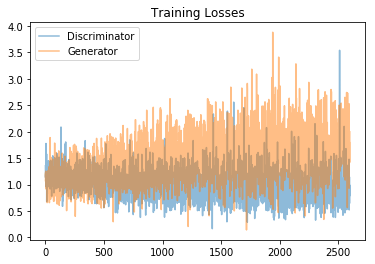

In [44]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [45]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [46]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

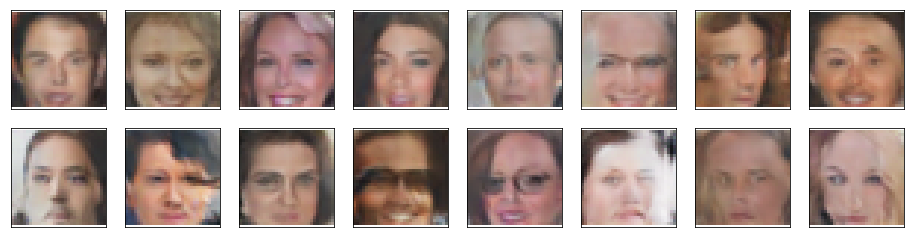

In [47]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** All of the generated samples are white celebrity, if the dataset was more diverse; I think the generator would be able to generate more diverse samples. The model is relatively small. If the model was deeper, we could train it with higher resolutions, which will enable the generator to generate samples with more details. I've tried training the model with 10 and 50 epochs. The increase in number of epochs showed improvement in the generated samples, which could indicate that training the model with more epochs can result in an even better generation.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.